In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchinfo import summary
from helper_functions import set_seeds

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# 1. Getting Data
The dataset we are going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset.

In [3]:
train_dir = os.path.join("Datasets", "pizza_steak_sushi_20_percent", "train")
test_dir = os.path.join("Datasets", "pizza_steak_sushi_20_percent", "test")

train_dir, test_dir

('Datasets/pizza_steak_sushi_20_percent/train',
 'Datasets/pizza_steak_sushi_20_percent/test')

# 2. FoodVision Mini model deployment experiment outline

### 3. Questions
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.
    
1. Performs well: 95% accuracy
2. Fast: as close to real-time (or faster) as possible (30 FPS+ or 30ms latency)
    * Latency = time for prediction to take place
  
To try and achieve these goals, we are going to build two model experiments:

1. EffNetB2 feature extractor (Just like we built in 15-Experiment Tracking).
2. ViT feature extractor (Just like we built in 16-Vision Transformer Implementation)

# 3. Experimenting with EffNetB2 feature Extractor

### 3.1 Creating an EffNetB2 feature extractor

In [4]:
def create_effnetb2_model(num_classes: int = 3,
                          seed: int =42):

    # 1. Setup pretrained EffNetB2 weights
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT   # DEFAULT = best available weights.

    # 2. Get EffNetB2 transforms
    effnetb2_transforms = effnetb2_weights.transforms()

    # 3. Setup pretrained model instance
    effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights)

    # 4. Freeze the base layers
    for param in effnetb2.parameters():
        param.requires_grad = False
        
    # 5. Change classifier head with random seed for reproducibility.    
    torch.manual_seed(seed)
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p = 0.3, inplace = True),
        nn.Linear(in_features = 1408, out_features = num_classes, bias = True)
        )
    
    return effnetb2, effnetb2_transforms

In [5]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3, seed = 42)

In [6]:
### Getting a summary of our model with torch.summary()
from torchinfo import summary

summary(
    model = effnetb2,
    input_size = (1, 3, 224, 224,),  # -> input_size = (BS, Color_channel, IMG_SIZE, IMG_SIZE)
    col_names = ["input_size", "output_size", "trainable"],  # names of columns you want.
    col_width = 20,
    row_settings = ["var_names"],
    )

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112, 112]    False
│    │    └─MBConv (0)                                       [1, 32, 112, 112]    [1, 16, 112, 112]    False
│    │    └─MBCo

### 3.2 Creating DataLoaders for EffNetB2

In [7]:
from going_moduler import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                 test_dir = test_dir,
                                                                                                 transform = effnetb2_transforms,
                                                                                                 batch_size = 8,
                                                                                                 num_workers = os.cpu_count())

print(f"{len(train_dataloader_effnetb2)}, {len(test_dataloader_effnetb2)}, {class_names}")

57, 19, ['pizza', 'steak', 'sushi']


### 3.3 Training EffNetB2 feature extractor

In [8]:
from going_moduler import engine

# Create Optimizer and Loss Function
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr = 1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model = effnetb2,
                                train_dataloader = train_dataloader_effnetb2,
                                test_dataloader = test_dataloader_effnetb2,
                                epochs = 10,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.8942 | Train acc: 0.6250 | Test Loss: 0.5729 | Test Acc: 0.9254
Epoch: 1 | Train Loss: 0.5982 | Train acc: 0.8026 | Test Loss: 0.4386 | Test Acc: 0.9342
Epoch: 2 | Train Loss: 0.4783 | Train acc: 0.8421 | Test Loss: 0.3388 | Test Acc: 0.9671
Epoch: 3 | Train Loss: 0.4186 | Train acc: 0.8772 | Test Loss: 0.3251 | Test Acc: 0.9320
Epoch: 4 | Train Loss: 0.3725 | Train acc: 0.8772 | Test Loss: 0.2822 | Test Acc: 0.9474
Epoch: 5 | Train Loss: 0.3672 | Train acc: 0.8750 | Test Loss: 0.2705 | Test Acc: 0.9518
Epoch: 6 | Train Loss: 0.3288 | Train acc: 0.8860 | Test Loss: 0.2578 | Test Acc: 0.9452
Epoch: 7 | Train Loss: 0.3408 | Train acc: 0.8860 | Test Loss: 0.2545 | Test Acc: 0.9386
Epoch: 8 | Train Loss: 0.3233 | Train acc: 0.8991 | Test Loss: 0.2567 | Test Acc: 0.9320
Epoch: 9 | Train Loss: 0.3267 | Train acc: 0.8728 | Test Loss: 0.2319 | Test Acc: 0.9518


### 3.4 Inspecting EffNetB2 loss curves

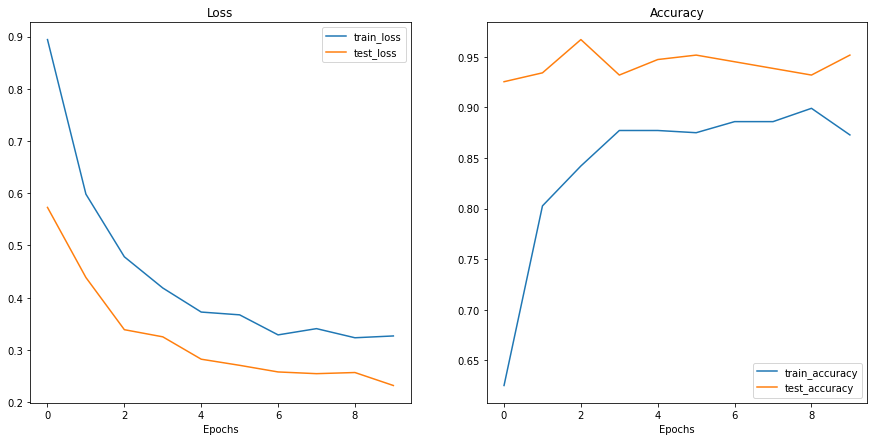

In [9]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [10]:
from going_moduler import utils

utils.save_model(model = effnetb2,
                 target_dir = "models",
                 model_name = "17_pretrained_effnetb2_20_percent.pth")

[INFO] Saving model to: models/17_pretrained_effnetb2_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 model

Check the model size, if its too large, we may not be able to deploy on our target device.

In [11]:
from pathlib import Path

# Get the model size in bytes and convert it to megabytes.
pretrained_effnetb2_model_size = Path(os.path.join("models", "17_pretrained_effnetb2_20_percent.pth")).stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.82 MB


### 3.7 Collecting EffNetB2 Feature Extractor stats

In [12]:
# Count number of paramaters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [13]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss" : effnetb2_results["test_loss"][-1], 
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.23187363147735596,
 'test_acc': 0.9517543859649122,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.824288368225098}

# 4. Experimenting with Vision Transformer feature extractor

### 4.1 Creating a ViT feature extractor

In [14]:
def create_vit_model(num_classes: int = 3,
                     seed: int = 42):
    
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    vit_transforms = weights.transforms()
    vit_model = torchvision.models.vit_b_16(weights = weights)
    
    # Freeze base layers
    for param in vit_model.parameters():
        param.requires_grad = False
        
    # Change classifier head with random seed for reproducibility.    
    torch.manual_seed(seed)
    vit_model.heads = nn.Sequential(nn.Linear(
        in_features = 768, 
        out_features = num_classes))

    return vit_model, vit_transforms

In [15]:
vit_model, vit_transforms = create_vit_model()

In [16]:
### Getting a summary of our model with torch.summary()
from torchinfo import summary

summary(
    model = vit_model,
    input_size = (1, 3, 224, 224,),  # -> input_size = (BS, Color_channel, IMG_SIZE, IMG_SIZE)
    col_names = ["input_size", "output_size", "trainable"],  # names of columns you want.
    col_width = 20,
    row_settings = ["var_names"],
    )

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768]        False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]        [1, 197, 768]        False
│    │    └─Enco

### 4.2 Create DataLoaders for ViT feature extractor

In [17]:
from going_moduler import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                       test_dir = test_dir,
                                                                                       transform = vit_transforms,
                                                                                       batch_size = 8,
                                                                                       num_workers = os.cpu_count())


print(f"{len(train_dataloader_vit)}, {len(test_dataloader_vit)}, {class_names}")

57, 19, ['pizza', 'steak', 'sushi']


### 4.3 Training ViT Feature Extractor

In [18]:
from going_moduler import engine

# Create Optimizer and Loss Function
optimizer = torch.optim.Adam(params = vit_model.parameters(),
                             lr = 1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Training function (engine.py)
set_seeds()
vit_results = engine.train(model = vit_model,
                                train_dataloader = train_dataloader_vit,
                                test_dataloader = test_dataloader_vit,
                                epochs = 10,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.3888 | Train acc: 0.8750 | Test Loss: 0.1153 | Test Acc: 0.9737
Epoch: 1 | Train Loss: 0.1348 | Train acc: 0.9539 | Test Loss: 0.0816 | Test Acc: 0.9803
Epoch: 2 | Train Loss: 0.0894 | Train acc: 0.9737 | Test Loss: 0.0755 | Test Acc: 0.9737
Epoch: 3 | Train Loss: 0.0635 | Train acc: 0.9868 | Test Loss: 0.0599 | Test Acc: 0.9737
Epoch: 4 | Train Loss: 0.0474 | Train acc: 0.9956 | Test Loss: 0.0617 | Test Acc: 0.9803
Epoch: 5 | Train Loss: 0.0416 | Train acc: 0.9956 | Test Loss: 0.0570 | Test Acc: 0.9737
Epoch: 6 | Train Loss: 0.0306 | Train acc: 0.9978 | Test Loss: 0.0579 | Test Acc: 0.9803
Epoch: 7 | Train Loss: 0.0255 | Train acc: 1.0000 | Test Loss: 0.0543 | Test Acc: 0.9803
Epoch: 8 | Train Loss: 0.0224 | Train acc: 1.0000 | Test Loss: 0.0528 | Test Acc: 0.9737
Epoch: 9 | Train Loss: 0.0174 | Train acc: 1.0000 | Test Loss: 0.0522 | Test Acc: 0.9737


### 4.4 Inspecting ViT loss curves

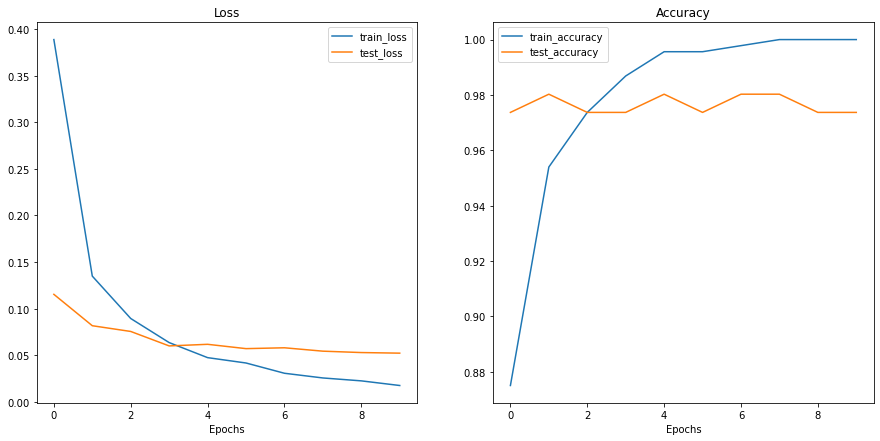

In [19]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.5 Saving ViT feature extractor

In [20]:
from going_moduler import utils

utils.save_model(model = vit_model,
                 target_dir = "models",
                 model_name = "17_pretrained_vit_20_percent.pth")

[INFO] Saving model to: models/17_pretrained_vit_20_percent.pth


### 4.6 Inspecting the size of our vit model

Check the model size, if its too large, we may not be able to deploy on our target device.

In [21]:
from pathlib import Path

# Get the model size in bytes and convert it to megabytes.
pretrained_vit_model_size = Path(os.path.join("models", "17_pretrained_vit_20_percent.pth")).stat().st_size / (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {round(pretrained_vit_model_size, 2)} MB")

Pretrained ViT feature extractor model size: 327.36 MB


### 4.7 Collecting ViT Feature Extractor stats

In [22]:
# Count number of paramaters in ViT
vit_total_params = sum(torch.numel(param) for param in vit_model.parameters())
vit_total_params

85800963

In [23]:
# Create a dictionary with ViT statistics
vit_stats = {"test_loss" : vit_results["test_loss"][-1], 
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.05216844586079548,
 'test_acc': 0.9736842105263158,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.36128330230713}

# 5. Making predictions with our trained models and timing them

our goal: 
1) Performs well (95% test accuracy)
2) Fast (30+ FPS)

To test criteria two:
1. Loop though test images.
2. Time how long each model takes to make a prediction on the image.

Let's work towards making a function called `pred_and_store()` to do so.

First we will need a list of test image paths.

In [24]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('Datasets/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg'),
 PosixPath('Datasets/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 PosixPath('Datasets/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 PosixPath('Datasets/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 PosixPath('Datasets/pizza_steak_sushi_20_percent/test/pizza/129666.jpg')]

### 5.1 Create a function to make across the test dataset

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms, a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionary.

In [25]:
import pathlib
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

# 1. Create a function that takes a list of paths and a trained PyTorch model and a series of transforms, a list of target class names and a target device.
def pred_and_store(paths: list[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: list[str], 
                   device = "cuda" if torch.cuda.is_available() else "cpu") -> list[dict]:
    
    # 2. Create an empty list (can return a full list of all predictions later).
    pred_list = []
    
    # 3. Loop through the target input paths (the rest of the steps will take place inside the loop).
    for path in tqdm(paths):
        
        # 4. Create an empty dictionary for each sample (prediction statistics will go in here).
        pred_dict = {}
        
        # 5. Get the sample path and ground truth class from the filepath.
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer.
        start_time = timer()
        
        # 7. Open the image using Image.open(path).
        img = Image.open(path)
        
        # 8. Transform the image to be usable with a given model.
        transformed_image = transform(img).unsqueeze(dim = 0).to(device)
        
        # 9. Prepare the model for inference by sending to the target device and turning on eval() mode.
        model = model.to(device)
        
        # 10. Turn on torch.inference_mode() and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim = 1) # -> turn logits into prediction probabilities.
            pred_label = torch.argmax(pred_prob, dim = 1)  # -> turn prediction probability into prediction label
            pred_class = class_names[pred_label.cpu()]     # Python variables lives in cpu so converted lables numpy array from tensor.
            
            # 11. Add the pred prob + pred class to empty dictionary from step 4.
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(dim = 0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)
            
            
        # 13. See if the predicted class matches the ground truth class.
        pred_dict["correct"] = class_name == pred_class
        
        # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
        pred_list.append(pred_dict)
        
    # 15. Return the list of prediction dictionary.
    return pred_list    

### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:
1. Device - we are going to hardcode our predictions to happen on CPU because you wont always be sure of having a GPU when you deploy your model.
2. Transforms - We want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms.

In [26]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = effnetb2,
                                          transform = effnetb2_transforms,
                                          class_names = class_names,
                                          device = "cpu")  # hardcode predictions to happen on CPU.

  0%|          | 0/150 [00:00<?, ?it/s]

In [27]:
effnetb2_test_pred_dicts

[{'image_path': PosixPath('Datasets/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9572,
  'pred_class': 'pizza',
  'time_for_pred': 0.1789,
  'correct': True},
 {'image_path': PosixPath('Datasets/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9989,
  'pred_class': 'pizza',
  'time_for_pred': 0.0986,
  'correct': True},
 {'image_path': PosixPath('Datasets/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.576,
  'pred_class': 'pizza',
  'time_for_pred': 0.114,
  'correct': True},
 {'image_path': PosixPath('Datasets/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9982,
  'pred_class': 'pizza',
  'time_for_pred': 0.1013,
  'correct': True},
 {'image_path': PosixPath('Datasets/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7338,
  'pred_class': 'piz

In [28]:
# Turn the effnetb2_test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,Datasets/pizza_steak_sushi_20_percent/test/piz...,pizza,0.9572,pizza,0.1789,True
1,Datasets/pizza_steak_sushi_20_percent/test/piz...,pizza,0.9989,pizza,0.0986,True
2,Datasets/pizza_steak_sushi_20_percent/test/piz...,pizza,0.5760,pizza,0.1140,True
3,Datasets/pizza_steak_sushi_20_percent/test/piz...,pizza,0.9982,pizza,0.1013,True
4,Datasets/pizza_steak_sushi_20_percent/test/piz...,pizza,0.7338,pizza,0.1437,True


In [30]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     143
False      7
Name: correct, dtype: int64

In [31]:
# Find the average time per predictions
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.3274


In [37]:
# Add average time per prediction to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.23187363147735596,
 'test_acc': 0.9517543859649122,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.824288368225098,
 'time_per_pred_cpu': 0.3274}

### 5.3 Making and timing predictions with ViT.

In [32]:
# Make predictions across test dataset with ViT
vit_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = vit_model,
                                          transform = vit_transforms,
                                          class_names = class_names,
                                          device = "cpu")  # hardcode predictions to happen on CPU.

  0%|          | 0/150 [00:00<?, ?it/s]

In [33]:
# Turn the vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,Datasets/pizza_steak_sushi_20_percent/test/piz...,pizza,0.9998,pizza,0.6395,True
1,Datasets/pizza_steak_sushi_20_percent/test/piz...,pizza,0.9998,pizza,0.6888,True
2,Datasets/pizza_steak_sushi_20_percent/test/piz...,pizza,0.9994,pizza,0.6683,True
3,Datasets/pizza_steak_sushi_20_percent/test/piz...,pizza,0.9998,pizza,0.5113,True
4,Datasets/pizza_steak_sushi_20_percent/test/piz...,pizza,0.9968,pizza,0.6306,True


In [34]:
# Check number of correct predictions
vit_test_pred_df.correct.value_counts()

True     146
False      4
Name: correct, dtype: int64

In [35]:
# Find the average time per predictions
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.6618


In [36]:
# Add average time per prediction to ViT stats dictionary
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.05216844586079548,
 'test_acc': 0.9736842105263158,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.36128330230713,
 'time_per_pred_cpu': 0.6618}

# 6.1 Comparing model results, predictions times and sizes

In [47]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame(data = [effnetb2_stats, vit_stats])

# Add column for model name
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.231874,95.18,7705221,29.824288,0.3274,EffNetB2
1,0.052168,97.37,85800963,327.361283,0.6618,ViT


## Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (for our use case, lower is better) - EffNetB2
* `model_size (MB)` - (for our use case of deploying to a mobile device, lower is better) - EffNetB2
* `time_per_pred_cpu` (for our use case, lower is better) - EffNetB2

In [49]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data = (df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns = ["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.224987,1.023009,11.135432,10.976332,2.021381


# 6.2 Visualizing the speed vs. performance tradeoff

So we have compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

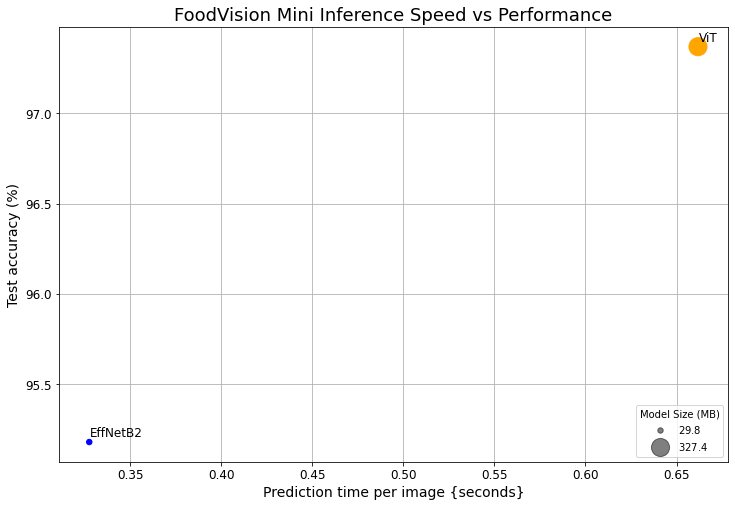

In [63]:
import matplotlib.pyplot as plt

# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize = (12, 8))
scatter = ax.scatter(data = df, 
                     x = "time_per_pred_cpu", y = "test_acc", 
                     c = ["blue", "orange"], s = "model_size (MB)")


# 2. Add titles and labels to make our plot look good.
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize = 18)
ax.set_xlabel("Prediction time per image {seconds}", fontsize = 14)
ax.set_ylabel("Test accuracy (%)", fontsize = 14)
ax.tick_params(axis = "both", labelsize = 12)
ax.grid(True)


# 3. Annotate the samples on the scatter plot so we know what's going on.
for index, row in df.iterrows():
    ax.annotate(s = row["model"],
                xy = (row["time_per_pred_cpu"] + 0.0006, row["test_acc"] + 0.03),
                size = 12)
    

# 4. Create a lagend based on the model size (model_size (MB)).
handles, labels = scatter.legend_elements(prop = "sizes", alpha = 0.5)
model_size_legend = ax.legend(handles, 
                              labels,
                              loc = "lower right",
                              title = "Model Size (MB)"
                              )

# Save the figure
#plt.savefig(os.path.join("images", "17-vit-vs-effnetb2.png"))

# 7. Bringing FoodVision Mini to life by creating Gradio demo

We have chosen to deploy EffNetB2 as it fulfils our criteria the best.

What is Gradio?

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

In [65]:
#!pip3 install gradio

### 7.1 Gradio Overview

Gradio helps you create machine learning demo.

Why create a demo?

So other people can try our models and we can test them in real-world.

Deployment is as important as training.

The overall premise of Gradio is to map inputs -> function/model -> outputs.

### 7.2 Creating a function to map our inputs and outputs

In [68]:
# Put our model on CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from

```
images of food -> ML model (EffNetB2) -> outputs (Food class label, prediction time)
```

In [72]:
def predict(img):
    # Start a timer
    start_time = timer()
    
    # Transform the input image for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(dim = 0)  # unsqueeze = add batch dimension on 0th index.
    
    # Put model into eval mode, make prediction
    effnetb2.eval()
    with torch.inference_mode():
        # Pass transformed image through the model and turn the prediction logits into probabilities.
        pred_probs = torch.softmax(effnetb2(img), dim = 1)
    
    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)
    
    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

In [88]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k = 1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img = image)
print(pred_dict)
print(pred_time)

Example test data path: Datasets/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg
[INFO] Predicting on image at path: Datasets/pizza_steak_sushi_20_percent/test/pizza/482858.jpg

{'pizza': 0.9970040917396545, 'steak': 0.0010967645794153214, 'sushi': 0.0018990918761119246}
0.1058


### 7.3 Creating a list of example images

In [91]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k = 3)]
example_list

[['Datasets/pizza_steak_sushi_20_percent/test/steak/550687.jpg'],
 ['Datasets/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'],
 ['Datasets/pizza_steak_sushi_20_percent/test/sushi/2416569.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input_image -> transform -> predict with EffNetB2 -> output: pred_prob, pred_time
```

In [92]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini"
description = "An EfficientNetB2 feature extractor computer vision model to classify images as pizza, steak or sushi"
article = "Created at 17-Pytorch-Model-Deployment"

# Create the Gradio demo
demo = gr.Interface(fn = predict, # maps inputs to outputs
                    inputs = gr.Image(type = "pil"),
                    outputs = [gr.Label(num_top_classes = 3, label = "Predictions"),
                               gr.Number(label = "Prediction time {s}")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article
                    )

# Launch the demo.
demo.launch(debug = True,  # Print erros locally
            share = True   # generate a publically sharable URL
            )                    

/home/dev_ashish/anaconda3/lib/python3.9/site-packages/gradio/deprecation.py:43: UserWarning: You have unused kwarg parameters in Interface, please remove them: {'example': [['Datasets/pizza_steak_sushi_20_percent/test/steak/550687.jpg'], ['Datasets/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'], ['Datasets/pizza_steak_sushi_20_percent/test/sushi/2416569.jpg']]}
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://bf45b190-8f39-47c6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.



KeyboardInterrupt



# 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Our Gradio demos from Jupyter Notebook are fantastic but they expire within 72 hours.

To fix this, we are going to prepare our app files so we can host them on Hugging Face Spaces.

### 8.1 What is Hugging Face Spaces?

Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or your organization’s profile. This allows you to create your ML portfolio, showcase your projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.

If Github is a place to show your coding ability, Hugging Face Space is a place to show your machine learning ability (through sharing ML demos that you have built).

### 8.2 Deployed Gradio App Structure

Let's start to put all of our app files into a single directory:

```
Jupyter Notebook -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> Deploy
```

### 8.3 Creating a `demos` folder to store our FoodVision app files

In [95]:
import os
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path(os.path.join("demos", "foodvision_mini"))

# Remove files that might already exist and create a new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents = True,
                                    exist_ok = True,
                                    )
    
else:
    foodvision_mini_demo_path.mkdir(parents = True,
                                    exist_ok = True,
                                    )
    
!ls demos

foodvision_mini


In [98]:
foodvision_mini_demo_path

PosixPath('demos/foodvision_mini')

### 8.4 Creating a folder of example images to use with our FoodVision Mini Demo

What we want:
   - 3 images in an example/ directory
   - images should be from the test set

In [111]:
# Create an example directory
foodvision_mini_examples_path = Path(os.path.join(foodvision_mini_demo_path, "examples"))
foodvision_mini_examples_path.mkdir(parents = True, exist_ok = True)

# Collect three test dataset image paths
foodvision_mini_examples = [Path(os.path.join("Datasets", "pizza_steak_sushi", "test", "pizza", "714866.jpg")),
                            Path(os.path.join("Datasets", "pizza_steak_sushi", "test", "steak", "1868005.jpg")),
                            Path(os.path.join("Datasets", "pizza_steak_sushi", "test", "sushi", "719108.jpg"))
                           ]

# Copy the three images to the examples directory
for example in foodvision_mini_examples:
    destination = os.path.join(foodvision_mini_examples_path, example.name)
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src = example, dst = destination)

[INFO] Copying Datasets/pizza_steak_sushi/test/pizza/714866.jpg to demos/foodvision_mini/examples/714866.jpg
[INFO] Copying Datasets/pizza_steak_sushi/test/steak/1868005.jpg to demos/foodvision_mini/examples/1868005.jpg
[INFO] Copying Datasets/pizza_steak_sushi/test/sushi/719108.jpg to demos/foodvision_mini/examples/719108.jpg


### Lets verify that we can get a list of lists from our `example` directory because `Gradio` requires examples in a list of list format.

In [116]:
import os

# Get example filepath in a list of list
example_list = [[os.path.join("examples", example)] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/1868005.jpg'], ['examples/714866.jpg'], ['examples/719108.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [125]:
# Create a source path for our target model
effnetb2_foodvision_mini_model_path = os.path.join("models", "17_pretrained_effnetb2_20_percent.pth")

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = os.path.join(foodvision_mini_demo_path, effnetb2_foodvision_mini_model_path.split("/")[1])

# Try to move the model file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    # Move the model
    shutil.move(src = effnetb2_foodvision_mini_model_path,
                dst = effnetb2_foodvision_mini_model_destination)
    print(f"[INFO] Model move complete.")
    
# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}")

[INFO] Attempting to move models/17_pretrained_effnetb2_20_percent.pth to demos/foodvision_mini/17_pretrained_effnetb2_20_percent.pth
[INFO] No model found at models/17_pretrained_effnetb2_20_percent.pth, perhaps its already been moved
[INFO] Model exists at demos/foodvision_mini/17_pretrained_effnetb2_20_percent.pth


### 8.6 Turning off EffNetB2 model into a Python Script (`model.py`)

We have a saved `.pth` model `state_dict` and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to a script so we can reuse it.

In [126]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
import torch.nn as nn


def create_effnetb2_model(num_classes: int = 3,
                          seed: int =42):

    # 1. Setup pretrained EffNetB2 weights
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT   # DEFAULT = best available weights.

    # 2. Get EffNetB2 transforms
    effnetb2_transforms = effnetb2_weights.transforms()

    # 3. Setup pretrained model instance
    effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights)

    # 4. Freeze the base layers
    for param in effnetb2.parameters():
        param.requires_grad = False
        
    # 5. Change classifier head with random seed for reproducibility.    
    torch.manual_seed(seed)
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p = 0.3, inplace = True),
        nn.Linear(in_features = 1408, out_features = num_classes, bias = True)
        )
    
    return effnetb2, effnetb2_transforms

Writing demos/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio App into a Python script (`app.py`)

The `app.py` file will have 4 major parts:
1. Imports and class names setup
2. Model and transforms preparation.
3. Predict function (`predict()`) 
4. Gradio app - our Gradio interface + launch command

In [128]:
%%writefile demos/foodvision_mini/app.py

### 1. Imports and class names setup ###
import gradio as gr
import os
import torch
from model import create_effnetb2_model
from timeit import default_timer as timer

# Setup class names
class_names = ["pizza", "steak", "sushi"]


### 2. Model and transforms preparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = len(class_names))

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f = "17_pretrained_effnetb2_20_percent.pth",
        map_location = torch.device("cpu")  # load the model to the cpu because model was trained on gpu.
        )
)
    

### 3. Predict function (predict()) ###
def predict(img):
    # Start a timer
    start_time = timer()
    
    # Transform the input image for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(dim = 0)  # unsqueeze = add batch dimension on 0th index.
    
    # Put model into eval mode, make prediction
    effnetb2.eval()
    with torch.inference_mode():
        # Pass transformed image through the model and turn the prediction logits into probabilities.
        pred_probs = torch.softmax(effnetb2(img), dim = 1)
    
    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)
    
    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time



### 4. Gradio app - our Gradio interface + launch command ###
# Create title, description and article
title = "FoodVision Mini"
description = "An EfficientNetB2 feature extractor computer vision model to classify images as pizza, steak or sushi"
article = "Created at 17-Pytorch-Model-Deployment"

# Create example_list
example_list = [[os.path.join("examples", example)] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn = predict, # maps inputs to outputs
                    inputs = gr.Image(type = "pil"),
                    outputs = [gr.Label(num_top_classes = 3, label = "Predictions"),
                               gr.Number(label = "Prediction time {s}")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article
                    )

# Launch the demo.
demo.launch(debug = True  # Print erros locally
            )                    


Writing demos/foodvision_mini/app.py


### 8.8 Creating requirements.txt

This requirements.txt file will tell our Hugging Face Space what all libraries dependencies our app requires.

In [132]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


# 9. We Deployed FoodVision Mini at HuggingFace using Gradio. Now Embedded it here

Hugging Face app link:- https://huggingface.co/spaces/devashish07/food_vision_mini

In [138]:
from IPython.display import IFrame

In [146]:
IFrame(src="https://devashish07-food-vision-mini.hf.space", frameborder="0", 
       width="950" ,height="750")